# Introduction to Time Series Clustering

## Datos de precios de electricidad

Actualización a febrero de 2024

## 1. Introducción

### 1.1. ¿Qué es Clustering?

El clustering es un tipo de problema de aprendizaje no supervisado y la idea principal es encontrar similitudes entre diferentes puntos de datos y emparejarlos en el mismo grupo de manera que esos puntos de datos en el mismo grupo (grupo) se parezcan más entre sí que los de otros. grupos. Es una de las principales tareas de la minería de datos exploratoria y se utiliza en muchos campos como la bioinformática, el reconocimiento de patrones, el análisis de imágenes, el aprendizaje automático, etc.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_assumptions_001.png" width="400">

Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html

### 1.2. ¿Qué son las series de tiempo?

Las series de tiempo son una realización de un proceso estocástico dentro de las múltiples posibles. Normalmente se representa como un flujo de datos que se crean al observar realizaciones de variables como ventas, temperatura, existencias, etc. con una frecuencia fija (anual, mensual, semanal, diaria, por hora, etc.). 

Las series de tiempo suelen indexarse respecto al tiempo y normalmente se utilizan para pronósticos.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/77/Random-data-plus-trend-r2.png" width="400">

Source: https://upload.wikimedia.org/wikipedia/commons/7/77/Random-data-plus-trend-r2.png

### 1.3. Agrupación de series de tiempo

El algoritmo K Means también se puede aplicar a series de tiempo. Lo único que debemos considerar es que la dimensionalidad del conjunto de datos es T, donde T es la longitud de la serie temporal.

Existe una biblioteca en Python llamada tslearn. Lo que hacen es aplicar pasos de preprocesamiento a las series temporales y adaptar algoritmos bien conocidos a las series temporales. Uno de estos algoritmos es el de agrupamiento que analizamos hasta ahora.

¿Por qué no podemos simplemente aplicar K Means? Hay un problema. Si dos series de tiempo son idénticas pero una se desplaza una sola unidad, la distancia calculada utilizando el método tradicional como el error cuadrático medio o el error absoluto medio sigue siendo muy grande incluso si la diferencia entre las dos series de tiempo es básicamente 0.

En lugar de calcular la distancia de la forma tradicional, queremos calcular el "camino más corto" y llamarlo distancia entre dos series de tiempo.

Esta operación se llama Distorsión de tiempo y distancia.

## 2. Análisis

### 2.1. Dependencias y Datos

In [1]:
# Dependencies
import pandas as pd
pd.set_option('display.max_columns', 200)
import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = [ 'xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 
           'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 
           'xkcd:cadet blue', 'xkcd:scarlet']
from tslearn.clustering import TimeSeriesKMeans

#
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install pip
#!pip install tslearn

In [3]:
# Opciones de visualizació de cifras:
pd.options.display.float_format = '{:,.2f}'.format #'${:,.2f}'

In [4]:
#

time_series_data = pd.read_csv('Datos_PML_Wide.csv')

time_series_data['Hora'] = time_series_data['Hora'] - 1 # para que la primera hora sea 0 y no 1

time_series_data['Periodo'] = pd.to_datetime( time_series_data['Fecha'] + ' ' + \
                                              time_series_data['Hora'].astype(str) + ':00:00')


time_series_data.head()

,Fecha,Hora,05FZA-115,04FMA-115,05AEP-115,06PRY-115,02SNS-115,03SLD-230,08PPO-115,03ING-69,06LBR-115,02LAV-400,02CJT-115,03IMP-115,03CNS-69,03RIG-115,05DGN-115,06RIB-138,04DYN-115,05SFB-115,04ORI-115,03AYL-115,03GKN-115,01PXA-85,05LGS-115,04EFR-230,02CIV-115,06MON-230,02ADD-115,01XOC-230,01TQC-115,08LAC-115,06MTN-115,05AMN-115,03GUD-69,06OVO-115,01TYA-230,03HYL-69,05LEX-115,02MDB-230,02MTL-115,03MIL-69,04TSR-115,06CYC-115,06MMD-230,02TPS-115,03COC-69,04CBA-115,03VYQ-115,05FXD-115,02RNA-115,03SPL-115,03NKA-69,04CUN-115,06MIG-138,04COC-115,03ZID-115,08SLC-230,01JDV-85,02ECM-115,03APZ-115,04LCH-115,05ISD-115,02MHT-115,06CMN-115,03UPT-115,05ALT-115,02TTP-115,06TMO-115,02CNJ-115,06CDT-115,02LMX-115,01AUR-230,01ATE-85,06PBS-115,03SEI-115,04CUS-115,01CTT-85,02KIM-115,02OWC-115,08CBU-115,06AUA-138,01NAU-85,05ARM-115,01ECA-230,01IXL-230,05CEJ-115,08NIZ-115,03ZLT-69,01ATU-115,05TBL-115,03TSM-115,05OAS-115,04SBK-115,05VEZ-115,06REY-138,03VAR-115,03MXT-115,02LRZ-115,04CUT-115,02MRO-115,05LEO-115,03LAS-115,03DEO-115,02PUE-115,06ALM-115,05DGD-115,01AVT-85,06POL-115,04GSV-115,08CAS-115,05SGP-115,02MID-400,06CYN-115,03LRE-115,03ABL-115,02HCO-115,03PUU-69,01TDK-230,02RBO-115,06LDC-115,06CIM-138,Periodo
0,2023-12-01,0,841.44,308.79,622.64,717.66,"1,798.51",894.98,"1,795.99","1,323.74",512.26,"1,701.05","1,838.93","1,234.67","1,122.03","1,053.16",842.67,668.40,319.72,768.44,356.12,"1,131.85","1,179.46","1,569.82",839.49,276.45,"1,613.24",731.46,"1,740.17","1,582.81","1,507.90","1,857.26",712.92,954.92,"1,114.20",551.58,"1,570.34","1,124.87",628.84,"1,635.58","1,711.69","1,135.28",421.81,774.83,333.39,"1,716.15","1,123.25",335.66,"1,282.44",625.06,"1,765.66","1,115.02","1,111.74",422.79,703.73,348.20,"1,197.50","1,784.87","1,570.75","1,701.90","1,250.18",355.24,722.61,"1,790.34",722.59,"1,227.64",726.37,"1,722.01",424.22,"1,815.78",703.55,"1,796.31","1,584.32","1,576.24",712.34,920.23,424.50,"1,570.29","1,699.06","1,671.25","1,826.54",742.73,"1,569.88",751.80,"1,576.18","1,587.61",624.09,"1,822.90","1,114.82","1,515.74",723.37,"1,241.55",797.39,330.21,695.07,678.51,949.32,"1,114.07","1,649.95",421.84,"1,744.80",739.33,"1,034.73","1,243.59","1,899.17",763.68,902.16,"1,576.31",404.20,400.11,"1,808.67",990.40,"1,735.26",717.09,"1,116.35","1,193.36","1,827.00","1,314.13","1,576.51","1,704.21",392.52,668.29,2023-12-01 00:00:00
1,2023-12-01,1,694.08,295.59,526.74,630.03,"1,147.06",723.96,"1,183.32",957.48,550.27,"1,104.06","1,222.70",900.97,840.29,817.53,695.06,595.93,302.45,639.24,326.61,841.96,866.58,"1,055.18",693.23,273.21,"1,080.00",635.82,"1,153.42","1,060.64","1,030.89","1,229.93",634.57,759.87,834.29,551.69,"1,057.06",841.71,531.00,"1,082.86","1,148.33",849.35,369.69,661.56,452.60,"1,135.12",840.46,312.52,919.10,528.39,"1,139.36",836.78,834.24,370.43,621.05,321.00,879.78,"1,181.66","1,056.27","1,123.48",910.72,326.01,605.51,"1,190.45",633.13,896.35,607.93,"1,142.26",498.68,"1,208.25",622.91,"1,192.73","1,059.98","1,062.31",627.42,737.70,371.58,"1,056.02","1,121.91","1,100.58","1,209.35",638.29,"1,055.29",626.77,"1,055.88","1,061.59",528.12,"1,202.80",835.09,"1,034.97",606.08,899.75,659.35,310.13,581.57,604.48,763.54,842.03,"1,092.88",369.87,"1,157.48",617.82,803.75,900.72,"1,270.16",654.88,722.12,"1,062.50",487.32,356.01,"1,197.23",785.04,"1,149.96",630.80,836.11,876.64,"1,216.31",951.41,"1,062.03","1,124.87",479.94,595.58,2023-12-01 01:00:00
2,2023-12-01,2,526.16,292.38,421.82,509.09,583.31,537.12,653.39,614.10,527.27,582.92,680.60,581.94,564.72,577.30,526.54,487.97,296.50,493.06,311.22,563.40,565.50,594.56,525.37,280.07,605.16,509.49,636.88,595.73,597.18,682.68,520.77,550.80,560.19,500.94,597.44,564.66,424.52,594.53,647.28,570.17,332.46,519.86,494.91,623.66,563.64,302.67,578.18,422.81,594.65,563.27,562.19,332.91,503.12,305.86,573.47,653.25,602.04,614.15,587.16,310.86,472.26,661.58,510.84,579.28,473.62,631.45,505.47,672.60,507.97,661.98,593.34,601.78,508.86,541.49,333.59,597.49,613.52,598.43,670.06,510.71,594.71,485.41,592.43,593.58,422.92,664

In [5]:
#

time_series_data.tail()

,Fecha,Hora,05FZA-115,04FMA-115,05AEP-115,06PRY-115,02SNS-115,03SLD-230,08PPO-115,03ING-69,06LBR-115,02LAV-400,02CJT-115,03IMP-115,03CNS-69,03RIG-115,05DGN-115,06RIB-138,04DYN-115,05SFB-115,04ORI-115,03AYL-115,03GKN-115,01PXA-85,05LGS-115,04EFR-230,02CIV-115,06MON-230,02ADD-115,01XOC-230,01TQC-115,08LAC-115,06MTN-115,05AMN-115,03GUD-69,06OVO-115,01TYA-230,03HYL-69,05LEX-115,02MDB-230,02MTL-115,03MIL-69,04TSR-115,06CYC-115,06MMD-230,02TPS-115,03COC-69,04CBA-115,03VYQ-115,05FXD-115,02RNA-115,03SPL-115,03NKA-69,04CUN-115,06MIG-138,04COC-115,03ZID-115,08SLC-230,01JDV-85,02ECM-115,03APZ-115,04LCH-115,05ISD-115,02MHT-115,06CMN-115,03UPT-115,05ALT-115,02TTP-115,06TMO-115,02CNJ-115,06CDT-115,02LMX-115,01AUR-230,01ATE-85,06PBS-115,03SEI-115,04CUS-115,01CTT-85,02KIM-115,02OWC-115,08CBU-115,06AUA-138,01NAU-85,05ARM-115,01ECA-230,01IXL-230,05CEJ-115,08NIZ-115,03ZLT-69,01ATU-115,05TBL-115,03TSM-115,05OAS-115,04SBK-115,05VEZ-115,06REY-138,03VAR-115,03MXT-115,02LRZ-115,04CUT-115,02MRO-115,05LEO-115,03LAS-115,03DEO-115,02PUE-115,06ALM-115,05DGD-115,01AVT-85,06POL-115,04GSV-115,08CAS-115,05SGP-115,02MID-400,06CYN-115,03LRE-115,03ABL-115,02HCO-115,03PUU-69,01TDK-230,02RBO-115,06LDC-115,06CIM-138,Periodo
1483,2024-01-31,19,486.25,319.59,402.03,474.80,518.07,508.27,577.99,612.88,511.04,513.85,597.95,548.75,522.48,537.71,486.25,461.55,332.21,453.57,349.47,520.15,524.61,536.72,481.31,330.62,544.43,475.16,540.09,536.50,541.85,593.42,486.66,498.02,517.36,478.85,539.57,522.33,405.07,529.63,600.01,530.28,377.23,485.04,476.59,533.01,521.27,342.56,530.59,403.36,524.21,525.94,518.39,376.98,470.39,336.96,535.59,559.30,537.70,533.74,558.79,349.02,431.15,578.98,478.41,545.75,433.22,555.65,484.04,561.14,473.97,547.02,533.86,543.37,474.81,512.12,378.79,536.51,532.55,531.10,576.28,465.87,536.90,445.82,533.61,534.02,399.97,587.72,520.18,541.56,431.26,535.65,462.31,336.12,418.62,462.20,534.40,545.29,530.96,376.50,510.62,439.29,534.00,535.51,643.01,481.07,474.44,543.51,480.70,353.30,571.25,521.38,538.65,473.81,518.45,530.07,573.56,615.83,542.60,534.48,476.90,462.02,2024-01-31 19:00:00
1484,2024-01-31,20,436.47,304.39,367.70,422.06,454.52,448.46,493.42,538.77,449.74,448.77,507.52,482.61,461.58,475.35,436.22,410.04,314.03,409.31,333.73,460.79,461.58,469.86,430.23,314.45,476.28,422.83,463.71,469.55,474.28,507.61,431.73,446.01,457.07,422.46,472.28,461.46,370.43,463.85,524.78,468.75,345.49,430.76,419.78,462.33,460.40,326.38,468.26,368.87,460.71,463.41,457.55,345.31,418.03,316.04,471.44,478.94,470.76,464.59,491.23,333.29,389.20,501.90,425.28,480.02,391.31,483.87,426.10,485.33,420.79,468.27,467.26,475.64,421.92,451.87,346.76,469.75,463.51,465.46,493.49,415.00,470.01,401.85,467.12,467.38,365.83,502.72,459.47,474.15,389.32,471.20,416.40,318.00,380.46,410.62,471.81,478.42,463.50,344.87,440.84,396.24,471.64,471.04,559.58,427.80,424.25,475.77,423.37,327.07,489.22,465.68,462.62,420.66,457.90,466.82,496.46,540.52,475.00,465.28,420.10,410.48,2024-01-31 20:00:00
1485,2024-01-31,21,439.17,273.85,365.81,422.96,450.76,448.80,484.48,536.08,447.71,444.77,498.10,482.93,466.59,477.94,439.01,411.66,288.22,407.40,309.40,465.36,462.25,466.06,433.40,288.80,472.30,423.65,458.23,465.66,470.50,499.63,432.09,450.58,461.84,421.44,468.55,466.07,368.65,460.02,519.64,473.30,328.78,432.17,418.40,457.65,464.87,300.12,465.52,367.04,456.64,464.62,462.92,328.59,419.31,291.70,472.62,472.44,466.99,460.31,491.39,308.96,387.72,495.97,426.24,480.47,389.78,478.26,424.50,480.10,421.42,462.73,463.43,471.91,422.70,451.92,330.20,466.09,459.26,461.57,486.63,415.57,466.22,400.58,463.31,463.54,364.01,494.69,464.46,470.25,387.81,471.22,414.74,292.28,378.60,412.20,472.37,479.66,459.47,328.15,436.19,394.45,473.68,471.00,553.11,429.36,429.59,472.05,421.94,307.11,482.22,470.73,457.16,421.29,463.98,468.47,491.24,536.86,471.26,461.04,418.81,412.24,2024-01-31 21:00:00
1486,2024-01-31,22,459.40,267.40,377.56,443.94,480.53,474.16,524.68,559.29,472.09,474.99,541.37,511.20,494.20,501.85,460.39,432.17,282.47,422.33,306.13,491.72

In [6]:
# Extraemos nombres de nodos:

Nodos_list = time_series_data.columns.tolist()[ 2 : time_series_data.shape[1] - 1]

Nodos_list

['05FZA-115',
 '04FMA-115',
 '05AEP-115',
 '06PRY-115',
 '02SNS-115',
 '03SLD-230',
 '08PPO-115',
 '03ING-69',
 '06LBR-115',
 '02LAV-400',
 '02CJT-115',
 '03IMP-115',
 '03CNS-69',
 '03RIG-115',
 '05DGN-115',
 '06RIB-138',
 '04DYN-115',
 '05SFB-115',
 '04ORI-115',
 '03AYL-115',
 '03GKN-115',
 '01PXA-85',
 '05LGS-115',
 '04EFR-230',
 '02CIV-115',
 '06MON-230',
 '02ADD-115',
 '01XOC-230',
 '01TQC-115',
 '08LAC-115',
 '06MTN-115',
 '05AMN-115',
 '03GUD-69',
 '06OVO-115',
 '01TYA-230',
 '03HYL-69',
 '05LEX-115',
 '02MDB-230',
 '02MTL-115',
 '03MIL-69',
 '04TSR-115',
 '06CYC-115',
 '06MMD-230',
 '02TPS-115',
 '03COC-69',
 '04CBA-115',
 '03VYQ-115',
 '05FXD-115',
 '02RNA-115',
 '03SPL-115',
 '03NKA-69',
 '04CUN-115',
 '06MIG-138',
 '04COC-115',
 '03ZID-115',
 '08SLC-230',
 '01JDV-85',
 '02ECM-115',
 '03APZ-115',
 '04LCH-115',
 '05ISD-115',
 '02MHT-115',
 '06CMN-115',
 '03UPT-115',
 '05ALT-115',
 '02TTP-115',
 '06TMO-115',
 '02CNJ-115',
 '06CDT-115',
 '02LMX-115',
 '01AUR-230',
 '01ATE-85',
 '

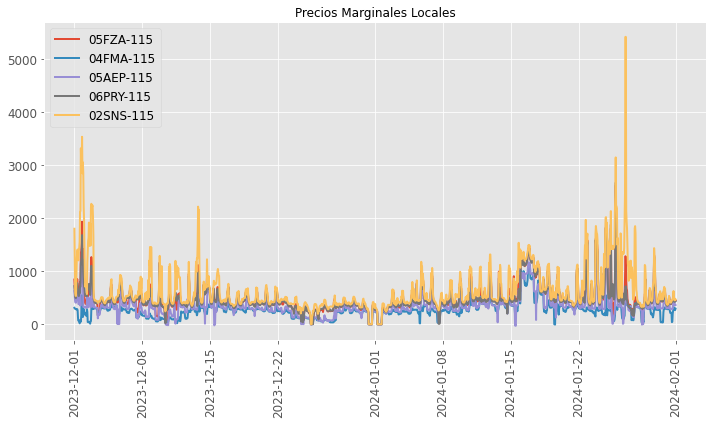

In [7]:
# Plot inicial

# Series Selección

plt.figure(figsize=(10, 6)) 

# Agrega cada serie de datos como una línea en el gráfico
plt.plot( time_series_data['Periodo'], time_series_data[ Nodos_list[0] ], label = Nodos_list[0])
plt.plot( time_series_data['Periodo'], time_series_data[ Nodos_list[1] ], label = Nodos_list[1])
plt.plot( time_series_data['Periodo'], time_series_data[ Nodos_list[2] ], label = Nodos_list[2])
plt.plot( time_series_data['Periodo'], time_series_data[ Nodos_list[3] ], label = Nodos_list[3])
plt.plot( time_series_data['Periodo'], time_series_data[ Nodos_list[4] ], label = Nodos_list[4])

# Configura el título y las leyendas
plt.title('Precios Marginales Locales')
plt.legend()

# Formato de la fecha en el eje X
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
plt.xticks(rotation = 90)  # Rota las fechas para mejor lectura

# Muestra el gráfico
plt.tight_layout()  
plt.show()

### 2.2 Agrupación

Como siempre, generar, conseguir o procesar los datos es lo complicado, el modelo es algo así:

In [8]:
#

data_array = np.array( time_series_data.T.drop( ['Periodo', 'Fecha', 'Hora'] ).values )

data_array

array([[841.44, 694.08, 526.16, ..., 439.17, 459.4, 448.44],
       [308.79, 295.59, 292.38, ..., 273.85, 267.4, 294.48],
       [622.64, 526.74, 421.82, ..., 365.81, 377.56, 363.07],
       ...,
       [1704.21, 1124.87, 614.71, ..., 461.04, 494.52, 484.53],
       [392.52, 479.94, 494.55, ..., 418.81, 443.24, 431.34],
       [668.29, 595.58, 487.51, ..., 412.24, 432.59, 421.76]],
      dtype=object)

In [9]:
#

model = TimeSeriesKMeans( n_clusters = 2, metric = "dtw", max_iter = 10)
#metric{“euclidean”, “dtw”, “softdtw”} (default: “euclidean”)

model.fit(data_array)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=2)

In [10]:
model.inertia_ #model.labels_

24462053.360853113

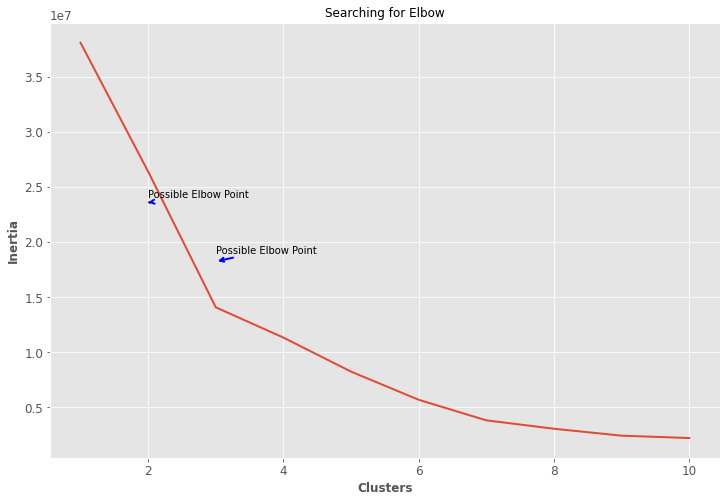

In [11]:
#

clusters = []

#
for i in range(1, 11):
    km = TimeSeriesKMeans( n_clusters = i, metric = "dtw", max_iter = 10 ).fit( data_array )
    clusters.append( km.inertia_ )

#
fig, ax = plt.subplots( figsize = (12, 8) )
sns.lineplot(x = list(range(1, 11)), y = clusters, ax = ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow
ax.annotate('Possible Elbow Point', xy = (2, 23590903), xytext = (2, 24000000), xycoords = 'data',          
             arrowprops = dict( arrowstyle = '->', connectionstyle = 'arc3', color = 'blue', lw = 2))

ax.annotate('Possible Elbow Point', xy = (3, 18243780), xytext = (3, 19000000), xycoords = 'data',          
             arrowprops = dict( arrowstyle = '->', connectionstyle = 'arc3', color = 'blue', lw = 2))

plt.show()

In [12]:
# selección Final:

#

model = TimeSeriesKMeans( n_clusters = 7, metric = "dtw", max_iter = 10)
#metric{“euclidean”, “dtw”, “softdtw”} (default: “euclidean”)

model.fit(data_array)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=7)

In [13]:
#

Nodos = time_series_data.T.drop( ['Periodo', 'Fecha', 'Hora'] ).index.tolist()

Nodos

['05FZA-115',
 '04FMA-115',
 '05AEP-115',
 '06PRY-115',
 '02SNS-115',
 '03SLD-230',
 '08PPO-115',
 '03ING-69',
 '06LBR-115',
 '02LAV-400',
 '02CJT-115',
 '03IMP-115',
 '03CNS-69',
 '03RIG-115',
 '05DGN-115',
 '06RIB-138',
 '04DYN-115',
 '05SFB-115',
 '04ORI-115',
 '03AYL-115',
 '03GKN-115',
 '01PXA-85',
 '05LGS-115',
 '04EFR-230',
 '02CIV-115',
 '06MON-230',
 '02ADD-115',
 '01XOC-230',
 '01TQC-115',
 '08LAC-115',
 '06MTN-115',
 '05AMN-115',
 '03GUD-69',
 '06OVO-115',
 '01TYA-230',
 '03HYL-69',
 '05LEX-115',
 '02MDB-230',
 '02MTL-115',
 '03MIL-69',
 '04TSR-115',
 '06CYC-115',
 '06MMD-230',
 '02TPS-115',
 '03COC-69',
 '04CBA-115',
 '03VYQ-115',
 '05FXD-115',
 '02RNA-115',
 '03SPL-115',
 '03NKA-69',
 '04CUN-115',
 '06MIG-138',
 '04COC-115',
 '03ZID-115',
 '08SLC-230',
 '01JDV-85',
 '02ECM-115',
 '03APZ-115',
 '04LCH-115',
 '05ISD-115',
 '02MHT-115',
 '06CMN-115',
 '03UPT-115',
 '05ALT-115',
 '02TTP-115',
 '06TMO-115',
 '02CNJ-115',
 '06CDT-115',
 '02LMX-115',
 '01AUR-230',
 '01ATE-85',
 '

In [14]:
# Prediciendo clases

y = model.predict(data_array)

y

array([1, 4, 1, 1, 6, 3, 0, 6, 1, 6, 0, 3, 3, 3, 1, 1, 4, 1, 4, 3, 3, 6,
       1, 4, 6, 1, 0, 6, 6, 0, 1, 1, 3, 1, 6, 3, 1, 6, 6, 3, 4, 1, 1, 0,
       3, 4, 3, 1, 6, 3, 3, 4, 1, 4, 3, 0, 6, 0, 3, 4, 1, 0, 1, 3, 1, 0,
       1, 0, 1, 0, 6, 6, 1, 3, 4, 6, 0, 2, 0, 1, 6, 1, 6, 6, 1, 5, 3, 6,
       1, 3, 1, 4, 1, 1, 3, 3, 0, 4, 0, 1, 3, 3, 0, 1, 1, 6, 1, 4, 0, 1,
       0, 1, 3, 3, 0, 6, 6, 0, 1, 1])

In [15]:
#

x = time_series_data.Periodo

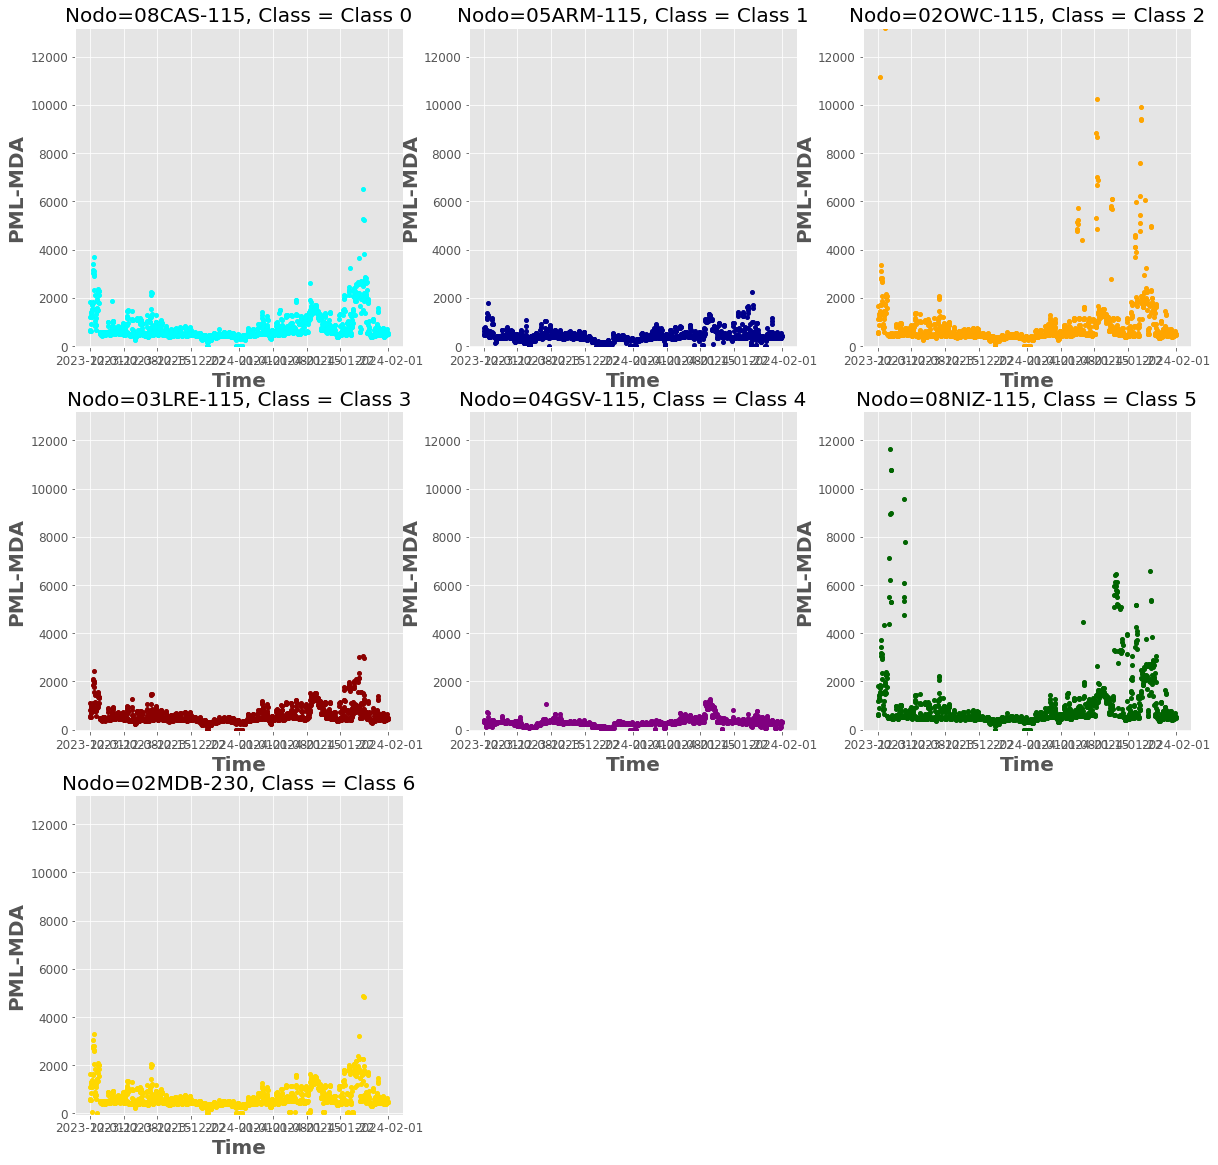

In [16]:
#
plt.figure( figsize = (20,20) )

k_dict = {'1':0,'2':1,'3':2,'4':3,'5':4,'6':5,'7':6} # Diccionario de labels

colors = ['cyan', 'darkblue', 'orange', 'darkred', 'purple', 'darkgreen', 'gold']

Names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']

for j in range(1,8):
    plt.subplot( 3, 3, j)
    
    k = np.random.choice( np.where( y == k_dict[ str(j) ] )[0] ) # Selección aleatoria de casos
    
    plt.plot( x, data_array[k], '.' ,color = colors[j-1] )
    plt.ylabel( 'PML-MDA', fontsize = 20 )
    plt.xlabel( 'Time', fontsize = 20)
    plt.title( 'Nodo=%s, Class = %s'%(Nodos[k], Names[j-1]), fontsize = 20)
    plt.ylim( data_array.min(), data_array.max() )

In [17]:
# Datos Finales
data = {
    'Nodo': Nodos,
    'Grupo': y 
}

df_Final = pd.DataFrame( data )

df_Final

,Nodo,Grupo
0,05FZA-115,1
1,04FMA-115,4
2,05AEP-115,1
3,06PRY-115,1
4,02SNS-115,6
...,...,...
115,03PUU-69,6
116,01TDK-230,6
117,02RBO-115,0
118,06LDC-115,1


In [18]:
# To CSV

df_Final.to_csv( 'Cluster_Nodos.csv', index = False )